In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv('/Users/dmitrybertnikov/Desktop/ds_learn/tests/synthetic_ecommerce_sales_2025.csv')
print('Общая информация по датасету')
df.head()

Общая информация по датасету


,order_id,customer_id,product_category,product_price,quantity,order_date,region,payment_method,delivery_days,is_returned,customer_rating,discount_percent,revenue
0,1,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Beauty,190.40,5,2023-02-21,Europe,BankTransfer,8,0,3.8,0,952.00
1,2,23b8c1e9-3924-46de-beb1-3b9046685257,Fashion,82.22,3,2023-10-13,North America,CreditCard,5,0,3.8,0,246.66
2,3,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Beauty,15.19,2,2023-06-28,Oceania,Cash,6,1,2.0,10,27.34
3,4,972a8469-1641-4f82-8b9d-2434e465e150,Electronics,310.65,2,2023-07-11,Europe,PayPal,9,0,2.9,5,590.23
4,5,17fc695a-07a0-4a6e-8822-e8f36c031199,Fashion,74.05,4,2023-02-24,Africa,PayPal,3,1,3.1,20,236.96


In [3]:
print('Информация по датасету')
df.info()
df.shape

Информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          100000 non-null  int64  
 1   customer_id       100000 non-null  object 
 2   product_category  100000 non-null  object 
 3   product_price     100000 non-null  float64
 4   quantity          100000 non-null  int64  
 5   order_date        100000 non-null  object 
 6   region            100000 non-null  object 
 7   payment_method    100000 non-null  object 
 8   delivery_days     100000 non-null  int64  
 9   is_returned       100000 non-null  int64  
 10  customer_rating   100000 non-null  float64
 11  discount_percent  100000 non-null  int64  
 12  revenue           100000 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 9.9+ MB


(100000, 13)

In [11]:
print('Описательная статистика по числовым значениям')
print(df.describe())

print('Описательна по категориальным признакам')
print(df.describe(include='object'))

Описательная статистика по числовым значениям
            order_id  product_price       quantity  delivery_days  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    50000.500000     250.962504       3.085480       4.984620   
std     28867.657797     141.743414       1.438706       2.579517   
min         1.000000       4.518000       1.000000       1.000000   
25%     25000.750000     128.387500       2.000000       3.000000   
50%     50000.500000     251.430000       3.000000       5.000000   
75%     75000.250000     372.270000       4.000000       7.000000   
max    100000.000000     500.000000       6.000000       9.000000   

         is_returned  customer_rating  discount_percent        revenue  
count  100000.000000    100000.000000     100000.000000  100000.000000  
mean        0.060600         3.500493          5.014700     734.148001  
std         0.238596         0.867731          6.138865     571.191290  
min         0.000000         2.000000   

In [4]:
df.isna().sum()

order_id            0
customer_id         0
product_category    0
product_price       0
quantity            0
order_date          0
region              0
payment_method      0
delivery_days       0
is_returned         0
customer_rating     0
discount_percent    0
revenue             0
dtype: int64

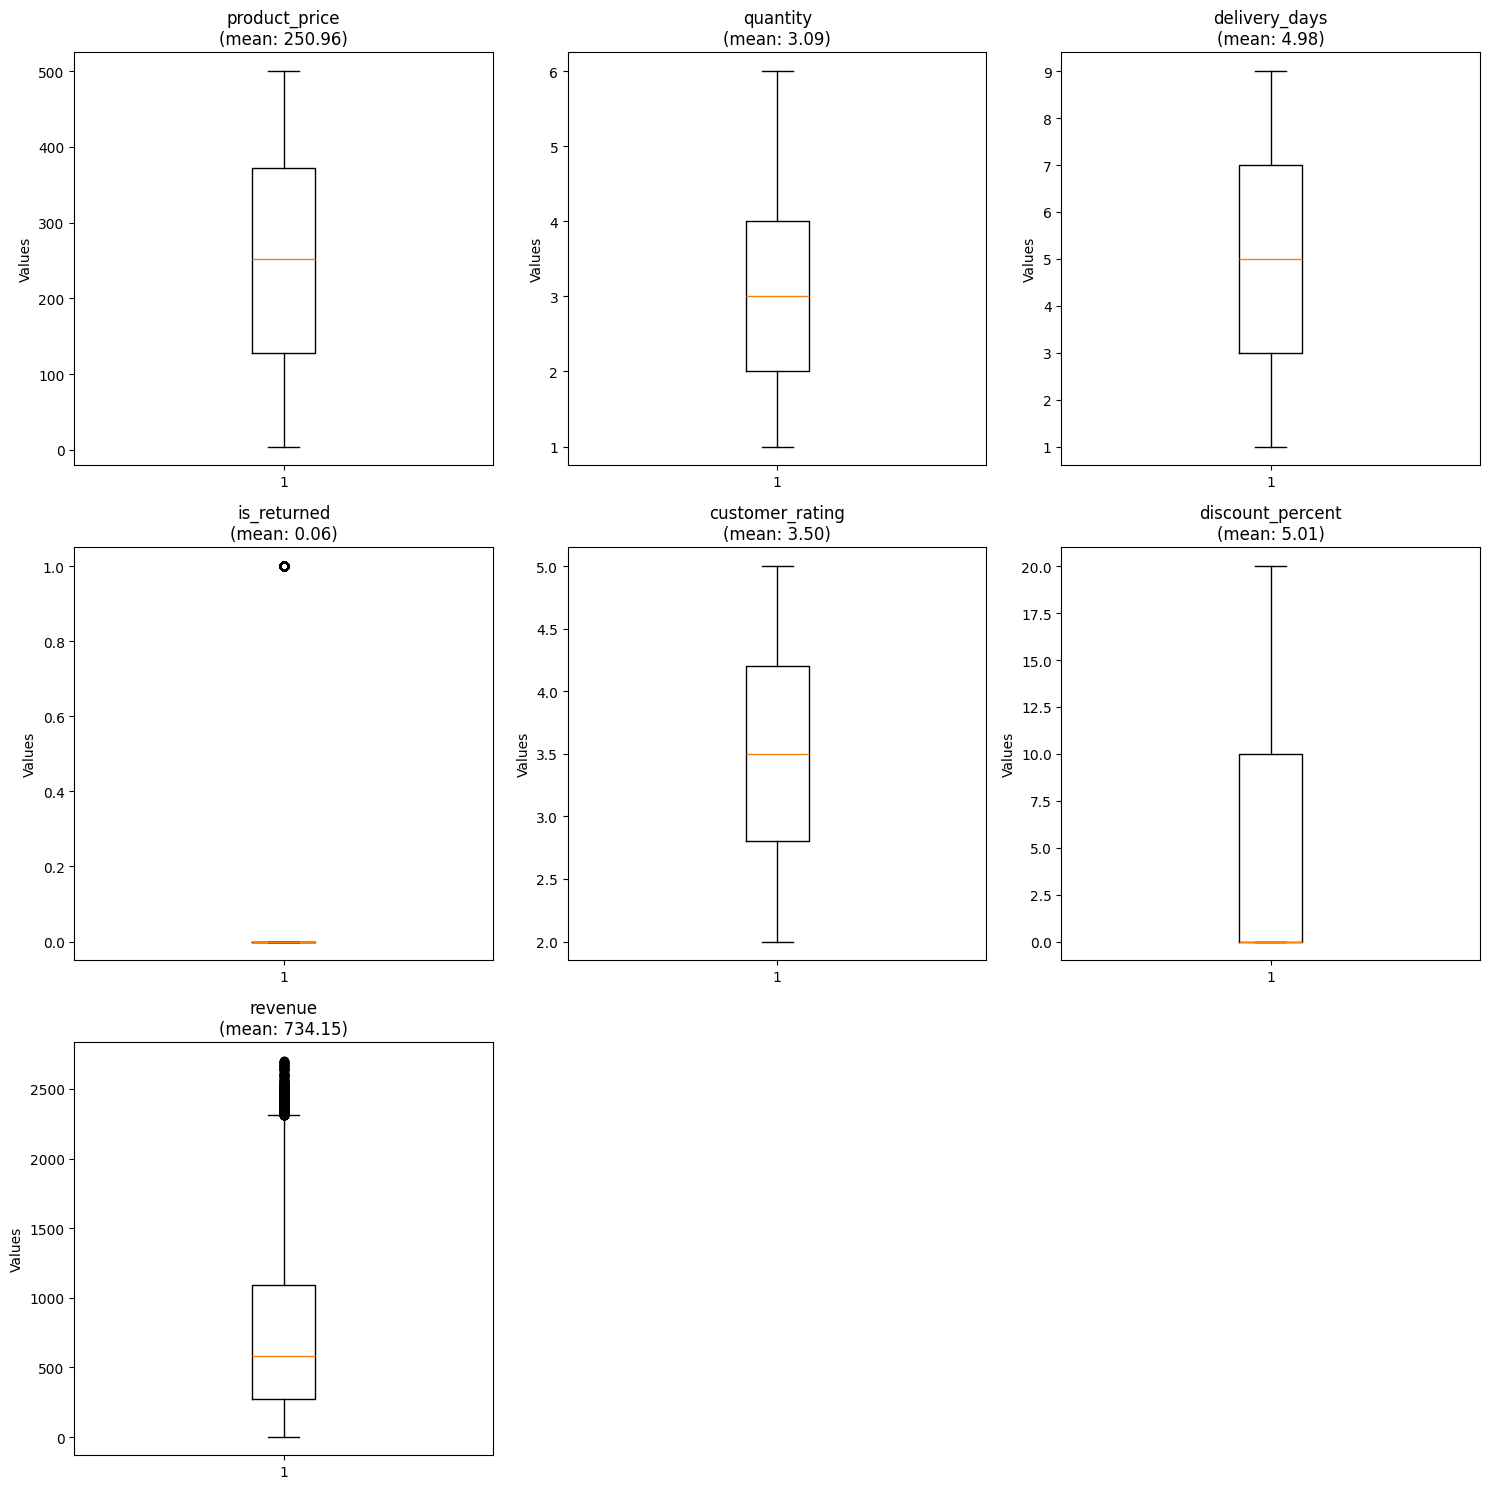

In [8]:
numeric = df.select_dtypes(include=['int64', 'float64'])

# Исключаем ID-колонки
id_like_columns = [col for col in numeric.columns if 'id' in col.lower()]
numeric_for_plot = numeric.drop(id_like_columns, axis=1)

# Создаем subplots
n_cols = 3  # 3 графика в строке
n_rows = (len(numeric_for_plot.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]  # Выравниваем оси

for i, col in enumerate(numeric_for_plot.columns):
    axes[i].boxplot(numeric_for_plot[col])
    axes[i].set_title(f'{col}\n(mean: {numeric_for_plot[col].mean():.2f})')
    axes[i].set_ylabel('Values')

# Скрываем пустые subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

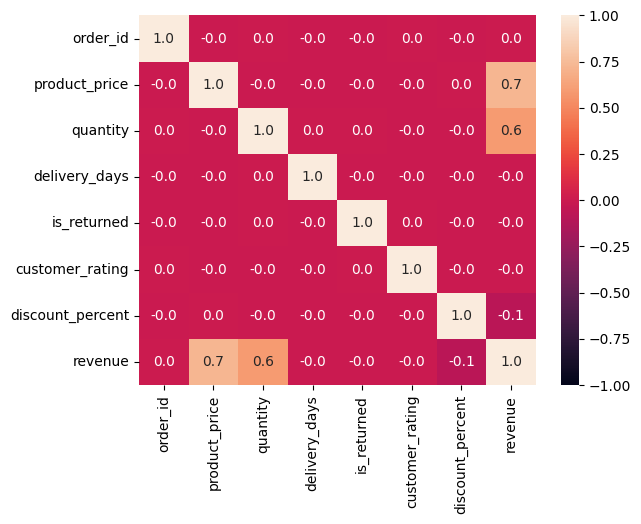

In [9]:
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True, fmt='.1f')
plt.show()

In [10]:
X = df.drop(columns=['is_returned'], axis=1)
y = df['is_returned']


In [11]:
def compare_classification_models_fixed(X, y, cat_features=None, cv_folds=5, test_size=0.2, random_state=42):
    """
    Исправленная версия с обработкой проблем в данных
    """
    
    # УДАЛЯЕМ ID-ПРИЗНАКИ!
    id_columns = ['customer_id', 'order_id']
    X_clean = X.drop(id_columns, axis=1, errors='ignore')
    
    # Обрабатываем дату
    if 'order_date' in X_clean.columns:
        X_clean = process_date_features(X_clean, 'order_date')
    
    # Обновляем список категориальных признаков
    if cat_features is None:
        cat_features = X_clean.select_dtypes(include=['object', 'category']).columns.tolist()
    else:
        # Убираем ID из категориальных
        cat_features = [col for col in cat_features if col not in id_columns]
    
    num_features = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_features = [col for col in num_features if col not in cat_features]
    
    print(f"🔍 Категориальные признаки: {cat_features}")
    print(f"🔢 Числовые признаки: {num_features}")
    print(f"🎯 Размерность данных: {X_clean.shape}")
    print(f"📊 Баланс классов: {y.value_counts(normalize=True).to_dict()}")
    
    # Разделяем данные
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Создаем preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
        ]
    )
    
    # Модели с настройками для несбалансированных данных
    models = {
        'LogisticRegression': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                random_state=random_state, 
                max_iter=1000,
                class_weight='balanced'  # Важно для дисбаланса!
            ))
        ]),
        'RandomForest': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                random_state=random_state, 
                n_jobs=-1,
                class_weight='balanced'
            ))
        ]),
        'GradientBoosting': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', GradientBoostingClassifier(random_state=random_state))
        ])
    }
    
    # CatBoost с обработкой дисбаланса
    if cat_features:
        catboost_model = CatBoostClassifier(
            cat_features=cat_features,
            random_state=random_state,
            verbose=False,
            auto_class_weights='Balanced'  # Балансировка классов
        )
    else:
        catboost_model = CatBoostClassifier(
            random_state=random_state,
            verbose=False,
            auto_class_weights='Balanced'
        )
    
    models['CatBoost'] = catboost_model
    
    results = []
    
    print("\n🎯 СРАВНЕНИЕ МОДЕЛЕЙ КЛАССИФИКАЦИИ")
    print("=" * 70)
    
    for name, model in models.items():
        print(f"\n📊 Обучение {name}...")
        
        try:
            # Обучение и кросс-валидация
            if name == 'CatBoost':
                model.fit(X_train, y_train)
                cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='roc_auc')
            else:
                model.fit(X_train, y_train)
                cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='roc_auc')
            
            # Предсказания
            if name == 'CatBoost':
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Метрики
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Precision, Recall, F1
            from sklearn.metrics import precision_score, recall_score, f1_score
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            results.append({
                'Model': name,
                'CV_ROC_AUC': f"{cv_mean:.4f} ± {cv_std:.4f}",
                'Test_Accuracy': accuracy,
                'Test_ROC_AUC': roc_auc,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1
            })
            
            print(f"✅ {name:20} | ROC-AUC: {roc_auc:.4f} | F1: {f1:.4f} | "
                  f"Precision: {precision:.4f} | Recall: {recall:.4f}")
            
        except Exception as e:
            print(f"❌ {name:20} | Ошибка: {str(e)[:50]}...")
            continue
    
    # Создаем DataFrame
    results_df = pd.DataFrame(results)
    
    if not results_df.empty:
        results_df = results_df.sort_values('Test_ROC_AUC', ascending=False)
        
        print("\n" + "=" * 70)
        best_model = results_df.iloc[0]
        print(f"🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model['Model']}")
        print(f"📊 Test ROC-AUC: {best_model['Test_ROC_AUC']:.4f}")
        print(f"🎯 F1-Score: {best_model['F1_Score']:.4f}")
    
    return results_df.round(4)

def process_date_features(df, date_column):
    """Извлекает фичи из даты"""
    df_processed = df.copy()
    
    if date_column in df_processed.columns:
        # Преобразуем в datetime
        df_processed[date_column] = pd.to_datetime(df_processed[date_column])
        
        # Извлекаем фичи
        df_processed['order_day_of_week'] = df_processed[date_column].dt.dayofweek
        df_processed['order_month'] = df_processed[date_column].dt.month
        df_processed['order_quarter'] = df_processed[date_column].dt.quarter
        df_processed['order_is_weekend'] = (df_processed[date_column].dt.dayofweek >= 5).astype(int)
        
        # Удаляем исходную колонку даты
        df_processed = df_processed.drop(date_column, axis=1)
    
    return df_processed

# Проверим баланс классов
def check_class_balance(y):
    """Проверяет баланс классов"""
    balance = y.value_counts(normalize=True)
    print(f"📊 Баланс классов:")
    for class_val, proportion in balance.items():
        print(f"   Класс {class_val}: {proportion:.2%}")
    
    if abs(balance[0] - balance[1]) > 0.3:
        print("⚠️  ВНИМАНИЕ: Сильный дисбаланс классов!")
    return balance

# Запуск анализа
def full_analysis(X, y, cat_features=None):
    """Полный анализ с исправлениями"""
    print("🔍 АНАЛИЗ ДАННЫХ")
    print("=" * 50)
    
    # Проверяем баланс
    class_balance = check_class_balance(y)
    
    # Запускаем исправленную функцию
    results_df = compare_classification_models_fixed(X, y, cat_features)
    
    print("\n📈 РЕКОМЕНДАЦИИ:")
    if results_df['Test_ROC_AUC'].max() < 0.7:
        print("❌ Модели работают плохо. Возможные причины:")
        print("   - Признаки не информативны для предсказания возвратов")
        print("   - Нужен feature engineering")
        print("   - Рассмотреть другие данные")
    
    return results_df

In [12]:
results_df = full_analysis(X, y, cat_features=['product_category', 'region', 'payment_method'])

🔍 АНАЛИЗ ДАННЫХ
📊 Баланс классов:
   Класс 0: 93.94%
   Класс 1: 6.06%
⚠️  ВНИМАНИЕ: Сильный дисбаланс классов!
🔍 Категориальные признаки: ['product_category', 'region', 'payment_method']
🔢 Числовые признаки: ['product_price', 'quantity', 'delivery_days', 'customer_rating', 'discount_percent', 'revenue', 'order_is_weekend']
🎯 Размерность данных: (100000, 13)
📊 Баланс классов: {0: 0.9394, 1: 0.0606}

🎯 СРАВНЕНИЕ МОДЕЛЕЙ КЛАССИФИКАЦИИ

📊 Обучение LogisticRegression...
✅ LogisticRegression   | ROC-AUC: 0.5711 | F1: 0.1601 | Precision: 0.1129 | Recall: 0.2748

📊 Обучение RandomForest...
✅ RandomForest         | ROC-AUC: 0.5498 | F1: 0.0016 | Precision: 0.5000 | Recall: 0.0008

📊 Обучение GradientBoosting...
✅ GradientBoosting     | ROC-AUC: 0.5651 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000

📊 Обучение CatBoost...
✅ CatBoost             | ROC-AUC: 0.5678 | F1: 0.1397 | Precision: 0.0894 | Recall: 0.3185

🏆 ЛУЧШАЯ МОДЕЛЬ: LogisticRegression
📊 Test ROC-AUC: 0.5711
🎯 F1-Score: 0.1601

📈